In [1]:
import sys, os
sys.path.insert(0, "{}/StarNet".format(os.getenv('HOME')))
import numpy as np
import h5py
import random
import matplotlib
import pandas as pd
import csv
import importlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json
import glob

from starnet.utils.data_utils.augment import convolve_spectrum, mask_tellurics
from starnet.utils.data_utils.restructure_spectrum import rebin, continuum_normalize, ensure_constant_sampling
from starnet.utils.data_utils.loading import load_data_from_h5, get_synth_spec_data, get_synth_wavegrid
from starnet.utils.plotting import plot_compare_estimates_gaiaeso_resid, make_boxplots_splitSNR
from starnet.models.cnn_models import StarNet2017, StarNet2017DeepEnsemble

from keras.models import load_model, Model
from astropy.io import fits as pyfits

/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
Using Tenso

In [2]:
# Define parameters needed for continuum fitting
LINE_REGIONS = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
SEGMENTS_STEP = 10.  # divide the spectrum into segments of 10 Angstroms

In [3]:
# Parameters for plotting
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True

# Define folder names

In [4]:
home = os.getenv('HOME')
scratch = os.getenv('SCRATCH')
print(scratch)
preprocessed_spectra_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/preprocessed/')
intrigoss_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/intrigoss/')
starnet_data_folder = os.path.join(home, 'StarNet/starnet/data/')
ambre_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/AMBRE/')                                   
model_folder = '/trained_model_ambre/'

model_path = scratch+model_folder
print(model_path)
os.listdir(model_path)

/scratch/nrpu88
/scratch/nrpu88/trained_model_ambre/


['model_parameter.json',
 'model_weights.h5',
 'hyperparameter.txt',
 'training.log',
 'weights.best.h5']

# Load trained model

In [5]:
model_weights = os.path.join(model_path, 'weights.best.h5')
model = load_model(model_weights)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### Collect info from model parameter file...

In [6]:
model_parameter_filepath = os.path.join(model_path, 'model_parameter.json')
if os.path.exists(model_parameter_filepath):
    with open(model_parameter_filepath, 'r') as f:
        
        datastore = json.load(f)
        
        print('Acquiring mu and sigma from model parameter file...')
        mu = np.asarray(datastore['mu'])
        sigma = np.asarray(datastore['sigma'])
        print('mu: {}'.format(mu))
        print('sigma: {}'.format(sigma))
        
        print('\nAcquiring target names...')
        targets = datastore['targetname']
        print('targets: {}'.format(targets))
        
        print('\nAcquiring h5py key for spectra...')
        spec_name = datastore['spec_key']
        print('spectrum key: {}'.format(spec_name))

Acquiring mu and sigma from model parameter file...
mu: [ 4.83410278e+03  2.90235556e+00 -9.86913889e-01  2.09722222e-01]
sigma: [1.56857792e+03 1.51689339e+00 1.58876817e+00 3.35277879e-01]

Acquiring target names...
targets: ['teff', 'logg', 'M_H', 'a_M']

Acquiring h5py key for spectra...
spectrum key: spectra_starnetnorm


# Load INTRIGOSS test datasets

#### Pre-processed spectra from the grid...

In [7]:
data_filename = 'ferre_test_100K.h5'
#data_filename = 'ambre_training_dataset.h5'
data_file = os.path.join(preprocessed_spectra_path, data_filename)
start_indx=0
end_indx=3000
spec_name = 'spectra_starnet_norm'
targets = ['teff','logg','M_H']
data = load_data_from_h5(data_file=data_file,
                       start_indx=start_indx,
                       end_indx=end_indx,
                       target_name=targets,
                       spec_name=spec_name)

X_synth, y_synth= data.X, data.y

# Mask telluric lines
#X_synth = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_synth, wave_grid)

# Zero-point bad values
for x in X_synth:
    x[x>1.03]=0
    x[x<0]=0

only non-normalized labels will be returned!


#### Set of 50 spectra at intra-mesh positions (provided by the INTRIGOSS team)

# Tests on INTRIGOSS dataset

#### Pre-processed spectra from the grid...

In [8]:
# Reshape data for compatibility with neural network
X = np.reshape(X_synth, (np.shape(X_synth)[0], np.shape(X_synth)[1], 1))

# Predict on synthetic spectra
#test_pred_intrigoss = model.predict(X, batch_size=5, verbose=0)
#test_pred_intrigoss = data.denormalize(test_pred_intrigoss, mu, sigma)
test_pred_ferre = model.predict(X, batch_size=5, verbose=0)
test_pred_ferre = data.denormalize(test_pred_ferre, mu, sigma)

In [9]:
all_targets = y_synth
all_pred = test_pred_ferre[:,[0,1,2]]
#z = np.divide(1, noise_synth)
print(all_targets.shape)
print(all_pred.shape)
label_names = [r'$T_{\textbf{eff}}$',
               r'log$g$',r'[M/H]']
centers = [np.arange(3750,7001,250), 
           np.arange(0.5, 5.01, 0.5),
           np.arange(-1.0, 0.51, 0.25)]
widths = [100, 0.1, 0.1]
ylims=[[-400,400],[-1.5,1.5],[-0.5,0.5]]

highsnr=150
lowsnr=100
difference = all_pred-all_targets
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
'''
make_boxplots_splitSNR(all_targets[:,:6], 
                       z,
                       difference[:,:6], 
                       highsnr, 
                       lowsnr, 
                       centers, widths, ylims,
                       label_names,
                       x_lab,
                       y_lab)
'''

(792, 3)
(792, 3)


'\nmake_boxplots_splitSNR(all_targets[:,:6], \n                       z,\n                       difference[:,:6], \n                       highsnr, \n                       lowsnr, \n                       centers, widths, ylims,\n                       label_names,\n                       x_lab,\n                       y_lab)\n'

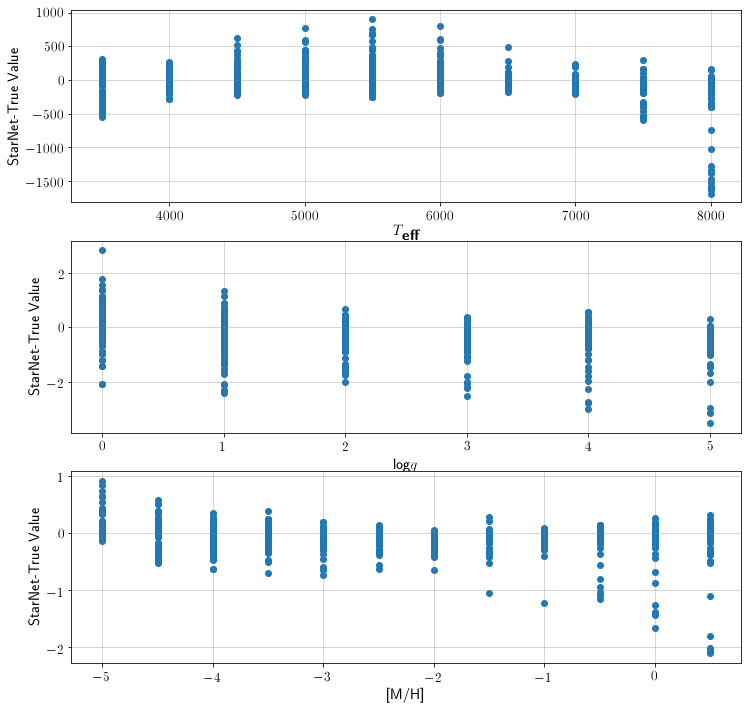

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
#fig.subplots_adjust(wspace=.05, hspace=1.1)


for i in range(3):
    axes[i].scatter(y_synth[:,i], difference[:,i])
    axes[i].yaxis.set_tick_params(labelsize=14)
    axes[i].xaxis.set_tick_params(labelsize=14)
    axes[i].set_xlabel(label_names[i], size=15)
    axes[i].set_ylabel('StarNet-True Value',size = 15)

In [19]:
plt.savefig('ambre_trained_ferre100K_test.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
off_grid_files = glob.glob(os.path.join(intrigoss_grid_path, 'off_grid_spectra/*f.fits'))

In [ ]:
obs_wave_filepath = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/UVES_4835-5395.npy')
wave_grid_obs = np.load(obs_wave_filepath)

# Collect spectra data
off_grid_X = []
off_grid_y = []
for off_grid_file in off_grid_files:
    flux, params = get_synth_spec_data(off_grid_file, grid_name='intrigoss')
    wave_grid_intrigoss = get_synth_wavegrid(off_grid_file, grid_name='intrigoss')
    
    # Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    wave_indices = (wave_grid_intrigoss > wave_min_request) & (wave_grid_intrigoss < wave_max_request)
    wave_grid_intrigoss = wave_grid_intrigoss[wave_indices]
    flux = flux[wave_indices]

    # Degrade resolution
    err_intrigoss = np.zeros(len(flux))
    _, flux, _ = convolve_spectrum(wave_grid_intrigoss, flux, err_intrigoss, to_resolution=47000)

    # Rebin to UVES wave grid
    flux = rebin(wave_grid_obs, wave_grid_intrigoss, flux)

    # Continuum normalize the spectra
    flux, _ = continuum_normalize(flux, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    off_grid_X.append(flux)
    off_grid_y.append(params)

In [ ]:
all_targets = y_synth
#all_pred = test_pred_intrigoss
all_pred = test_pred_ambre
z = np.divide(1, noise_synth)

label_names = [r'$T_{\textbf{eff}}$',
               r'log$g$',r'[M/H]',
               r'[$\alpha$/M]',
               r'$v_{\textbf{rot}}$',
               r'$v_\textbf{{rad}}$',
               r'$v_\textbf{{micro}}$']
"""
centers = [np.arange(3750,7001,250), 
           np.arange(0.5, 5.01, 0.5),
           np.arange(-1.0, 0.51, 0.25),
           np.arange(-0.25, 0.51, 0.25),
           np.arange(0, 80, 10),
           np.arange(-5, 5.1, 5)]
"""
centers = [np.arange(2500,8500,250), 
           np.arange(-0.5, 6.0, 0.5),
           np.arange(-5.0, 1.5, 0.25),
           np.arange(-0.4, 1.0, 0.2),
           np.arange(0, 80, 10),
           np.arange(-5, 5.1, 5)]
widths = [1000, 0.1, 2.5, 0.1, 5, 12.5]
ylims=[[-150,150], [-0.5,0.5], [-0.2,0.2], [-0.2,0.2], [-5,5], [-5,5]]
highsnr=150
lowsnr=100
difference = all_pred-all_targets
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
make_boxplots_splitSNR(all_targets[:,:6], 
                       z, 
                       difference[:,:6], 
                       highsnr, 
                       lowsnr, 
                       centers, widths, ylims,
                       label_names,
                       x_lab,
                       y_lab)

#### Set of 50 spectra at intra-mesh positions (provided by the INTRIGOSS team)

In [ ]:
# Reshape data for compatibility with neural network
X = np.reshape(off_grid_X, (np.shape(off_grid_X)[0], np.shape(off_grid_X)[1], 1))

# Predict on synthetic spectra
test_pred_off_grid = model.predict(X, batch_size=5, verbose=0)
test_pred_off_grid = data.denormalize(test_pred_off_grid, mu, sigma)

In [ ]:
%matplotlib inline
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure(figsize=(5, 5)) 
gs = gridspec.GridSpec(4, 1,  width_ratios=[1])

all_targets = np.asarray(off_grid_y)
all_pred = np.asarray(test_pred_off_grid)[:,:5]
difference = all_pred-all_targets

# Calculate statistics for the predictions
average_quadratic_diff_teff = np.nanmean(np.abs(difference[:,0]))
average_quadratic_diff_logg = np.nanmean(np.abs(difference[:,1]))
average_quadratic_diff_feh = np.nanmean(np.abs(difference[:,2]))
average_quadratic_diff_alpha = np.nanmean(np.abs(difference[:,3]))

ax = plt.subplot(gs[0,0])
sc = plt.scatter(all_targets[:,0], difference[:,0], marker="x", s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{Teff}}=${0:6.0f}K'.format(average_quadratic_diff_teff,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-300,300))
#plt.xlabel(r'$T_{\textrm{eff}}$')
plt.ylabel(r'$\Delta$ $T_{\textrm{eff}}$')


ax = plt.subplot(gs[1,0])
sc = plt.scatter(all_targets[:,1], difference[:,1], marker="x", s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{logg}}=${0:6.2f}'.format(average_quadratic_diff_logg,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-0.5,0.5))
#plt.xlabel(r'log$g$')
plt.ylabel(r'$\Delta$ log$g$')

ax = plt.subplot(gs[2,0])
sc = plt.scatter(all_targets[:,2], difference[:,2], marker="x", s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{[Fe/H]}}=${0:6.2f} dex'.format(average_quadratic_diff_feh,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-0.5,0.5))
#plt.xlabel(r'[Fe/H]')
plt.ylabel(r'$\Delta$ [Fe/H]')

ax = plt.subplot(gs[3,0])
sc = plt.scatter(all_targets[:,2], difference[:,3], marker="x", s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{[\alpha/M]}}=${0:6.2f} dex'.format(average_quadratic_diff_alpha,width=6)
ax.annotate(annotation, xy=(0.03, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-0.5,0.5))
#plt.xlabel(r'[$\alpha$/M]')
plt.ylabel(r'$\Delta$ [$\alpha$/M]')
fig.subplots_adjust(wspace=.1, hspace=0.4)
#fig.suptitle('MRGs and MRDs')

## Load UVES dataset

In [7]:
import pickle

'''
file_name = 'UVES_GE_MW_4835-5395_updated.h5' #'UVES_GE_MW_4835-5395.h5' #'UVES_GE_MW_5840-6800.h5'
#file_name = 'UVES_GE_MW_4835-5395_csigma.h5'
with h5py.File(os.path.join(preprocessed_spectra_path, file_name), "r") as f:
        X_uves = f['spectra'][:]
        y_uves = np.column_stack([f['teff'][:], f['logg'][:], f['fe_h'][:][:]
'''

with open('ferre_flux', 'rb') as flux_f:
 
    # Step 3
    ferre_flux = pickle.load(flux_f)
    
with open('ferre_teff', 'rb') as teff_f:
 
    # Step 3
    ferre_teff = pickle.load(teff_f)
    
with open('ferre_feh', 'rb') as feh_f:
 
    # Step 3
    ferre_feh = pickle.load(feh_f)
    
with open('ferre_logg', 'rb') as logg_f:
 
    # Step 3
    ferre_logg = pickle.load(logg_f)

In [8]:
X_ferre = np.asarray(ferre_flux)
Y_ferre = np.column_stack([ferre_teff, ferre_logg, ferre_feh])

print(X_ferre.shape)
print(Y_ferre.shape)

(792, 39436)
(792, 3)


In [9]:
# Take care of bad values
for spec in X_ferre:
    spec[spec>1.03]=0
    spec[spec<0]=0
    
# Mask telluric lines
#X_ferre = mask_tellurics(os.path.join(starnet_data_folder, 'telluric_lines.txt'), X_ferre, wave_grid)

## Predict on UVES dataset

In [12]:
# Reshape data for compatibility with neural network
X = np.reshape(X_ferre, (np.shape(X_ferre)[0], np.shape(X_ferre)[1], 1))

# Predict on UVES spectra
test_pred_ferre = model.predict(X, batch_size=5, verbose=0)
test_pred_ferre = data.denormalize(test_pred_ferre, mu, sigma)

NameError: name 'data' is not defined

In [ ]:
%matplotlib inline
all_targets = Y_ferre[:,[0,1,2]]
all_pred = test_pred_ferre[:,[0,1,2]]#,5,6]]
z = snr_uves

groups_wanted = [b'GE_SD_BM']#b'GE_MW', b'GE_CL', b'GE_MW_BL', , b'GE_SD_GC', b'GE_SD_OC']

snr_max=120
x_lab=r'GES iDR4'
y_lab=r'StarNet - GES iDR4'
label_names = [r'T$_{\textbf{eff}}$',r'log(g)',r'[Fe/H]',r'v$_\textbf{{rad}}$',r'v$_\textbf{{micro}}$']
cmap = 'Reds'
plot_lims = [[3000., 7500.], [0.0, 5.5], [-1.5, 1.0], [-250, 250], [0.5, 2.2]]
x_tick_stepsizes = [500, 0.5, 0.5, 50, 0.5]
grid_lims = [[3750., 7000.], [0.5, 5], [-1.0, 0.5], [-200, 200], [1., 2.]]
resid_lims = [[-800., 800.], [-1.5, 1.5], [-0.5, 0.5], [-30, 30], [-1, 1]]

plot_compare_estimates_gaiaeso_resid(x_data=all_targets, 
                                     y_data=all_pred, 
                                     snr=z, 
                                     savename=None, 
                                     x_lab=x_lab, 
                                     y_lab=y_lab, 
                                     snr_max=snr_max, 
                                     cmap=cmap,
                                     label_names=label_names,
                                     lims=plot_lims,
                                     grid_lims=grid_lims,
                                     resid_lims=resid_lims,
                                     x_tick_steps=x_tick_stepsizes,
                                     indx=np.shape(all_targets)[1],
                                     categories=ges_type,
                                     groups_wanted=groups_wanted)

# Now to predict on the Gaia Benchmark Stars

- All spectra for the benchmark stars were downloaded from ftp://obsftp.unige.ch/pub/sblancoc/Gaia_Benchmark_Stars_Library/
- Temperatures and surface gravities from http://cdsads.u-strasbg.fr/abs/2015A&A...582A..49H
- Metallicities from http://cdsads.u-strasbg.fr/abs/2014A&A...564A.133J



In [11]:
import os
import numpy as np
import pandas as pd

In [12]:
benchmarks_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/flames-uves/benchmark-stars/')
ref_file = os.path.join(benchmarks_path, 'benchmark_stars_overview.txt')
ref = np.genfromtxt(ref_file, dtype=str, delimiter='\t')

In [13]:
df_full = pd.DataFrame(data=ref[1:,1:],    # values
             index=ref[1:,0],    # 1st column as index
             columns=ref[0,1:])  # 1st row as the column names

# Grab only spectra taken with UVES
df_uves_all = df_full[df_full['origin']=='BS_UVES']

# Some entries appear twice, so separate these
list_2 = [ID for ID in df_uves_all.ID if '-2' in ID] # All entries with a '-2' in the ID name
df_uves1 = df_uves_all[~df_uves_all['ID'].isin(list_2)].copy(deep=False)
df_uves2 = df_uves_all[df_uves_all['ID'].isin(list_2)].copy(deep=False)

# Convert everything from strings to numbers
df_uves1['Teff'] = df_uves1['Teff'].astype(int)
df_uves1['logg'] = df_uves1['logg'].astype(float)
df_uves1['[Fe/H]'] = df_uves1['[Fe/H]'].astype(float)
df_uves2['Teff'] = df_uves2['Teff'].astype(int)
df_uves2['logg'] = df_uves2['logg'].astype(float)
df_uves2['[Fe/H]'] = df_uves2['[Fe/H]'].astype(float)

df_uves1 = df_uves1.drop('alfTau')

In [14]:
df_uves1

,ID,origin,snr,R,HIP_ID,Group,Teff,eTeff,logg,elogg,...,[Ni/H],e[Ni/H],[Sc/H],e[Sc/H],[Si/H],e[Si/H],[Ti/H],e[Ti/H],[V/H],e[V/H]
Arcturus,UVES_Arcturus-1,BS_UVES,283.0,95000.0,HIP69673,FGK giants,4286,35,1.640,0.09,...,-0.49,0.1,-0.43,0.15,-0.25,0.07,-0.31,0.11,-0.44,0.14
HD102200,UVES_HD102200,BS_UVES,160.0,51690.0,HIP57360,Metal-poor,6155,80,4.220,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HD106038,UVES_HD106038,BS_UVES,254.0,47254.0,HIP59490,Metal-poor,6121,80,4.550,0.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HD122563,UVES_HD122563-1,BS_UVES,318.0,72000.0,HIP68594,FGK giants,4587,60,1.610,0.07,...,-2.69,0.13,-2.5,0.11,-2.33,0.09,-2.5,0.15,-2.7,0.13
HD140283,UVES_HD140283-1,BS_UVES,293.0,78000.0,HIP76976,FGK subgiants,5522,105,3.580,0.11,...,-2.61,0.11,-2.67,0.07,-2.25,0.06,-2.42,0.12,NaN,NaN
HD201891,UVES_HD201891,BS_UVES,107.0,66320.0,HIP104659,Metal-poor,5948,80,4.300,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HD298986,UVES_HD298986,BS_UVES,173.0,51690.0,HIP50382,Metal-poor,6223,100,4.190,0.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HD84937,UVES_HD84937-1,BS_UVES,224.0,72000.0,HIP48152,F dwarfs,6356,97,4.060,0.04,...,-2.06,0.15,-1.9,0.16,-1.73,0.18,-1.66,0.12,NaN,NaN
Procyon,UVES_Procyon-1,BS_UVES,360.0,75000.0,HIP37279,F dwarfs,6554,84,4.000,0.02,...,-0.11,0.09,-0.13,0.07,-0.03,0.08,-0.07,0.1,-0.14,0.1
Sun,UVES_Sun-1,BS_UVES,383.0,78000.0,NaN,G dwarfs,5771,1,4.438,0.0002,...,0.0,0.11,0.0,0.15,0.0,0.08,0.0,0.08,0.0,0.05


In [15]:
df_uves1.to_csv(r'gaia_eso_stars.csv')

In [16]:
# Define parameters needed for continuum normalization
wave_grid_uves = wave_grid
line_regions = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
segments_step = 10. # divide the spectrum into segments of 10 Angstroms

NameError: name 'wave_grid' is not defined

In [17]:
telluric_filename = 'telluric_lines.txt'
telluric_file = os.path.join(starnet_data_folder, telluric_filename)
fluxes_norm = []
fluxes_nonorm = []
continuums = []
starnet_teff = []
starnet_logg = []
starnet_feh = []
starnet_alpha = []
df_uves = df_uves1
for index, star in df_uves.iterrows():
    print(star['ID'])
    # Load .txt file containing wavelength and flux arrays
    x = np.loadtxt(benchmarks_path + '%s_47000.txt' % star['ID'], skiprows=1)
    wave, flux = x[:,0], x[:,1]
    wave*=10.  # Convert to angstroms

    # Rebin to UVES grid
    flux = rebin(wave_grid_uves, wave, flux)

    fluxes_nonorm.append(flux)
    # Continuum normalize the spectrum
    flux, cont = continuum_normalize(flux, line_regions, wave_grid_uves, 10)
    
    continuums.append(cont)
    fluxes_norm.append(flux)

    # Mask telluric lines
    flux = mask_tellurics(telluric_file, flux, wave_grid)
    flux[flux>1.03]=0
    flux[flux<0]=0

    # Reshape data for compatibility with neural network
    X = np.reshape(flux, (np.shape(np.atleast_2d(flux))[0], np.shape(np.atleast_2d(flux))[1], 1))

    # Predict on spectra
    test_pred = model.predict(X, batch_size=1, verbose=0)
    test_pred = data.denormalize(test_pred, mu, sigma)
    
    starnet_teff.append(int(test_pred[0][0]))
    starnet_logg.append(test_pred[0][1])
    starnet_feh.append(test_pred[0][2])
    starnet_alpha.append(test_pred[0][3])
    
df_uves['StarNet Teff'] = starnet_teff
df_uves['StarNet logg'] = starnet_logg
df_uves['StarNet [Fe/H]'] = starnet_feh
df_uves['StarNet [alpha/M]'] = starnet_alpha

UVES_Arcturus-1


NameError: name 'wave_grid_uves' is not defined

### In order to calculate statistics of the predictions, I follow the method outlined in R. Smiljanic et al. (2014, https://arxiv.org/pdf/1409.0568.pdf):

1. Split the stars into three groups, covering separate parts of parameter space:
    - **metal-rich dwarfs (MRD)**: [Fe/H] $\gt$ -1.00 and log*g* $\gt$ 3.5
    - **metal-rich giants (MRG)**: [Fe/H] $\gt$ -1.00 and log*g* $\leq$ 3.5
    - **metal-poor stars**: [Fe/H] $\leq$ -1.00 **NOTE:** INTRIGOSS doesn't go below -1.00 in [Fe/H], so these are not included in the analysis
    
2. Calculate the average quadratic difference between the reference and the derived atmospheric parameters of the stars. If this average quadratic difference is within ± 100 K and ± 0.20 dex of the reference values, the results are considered to be very accurate.


In [ ]:
# Separate the MRDs from the MRGs from MPs
metal_rich = df_uves['[Fe/H]'] > -1.
metal_poor = df_uves['[Fe/H]'] <= -1.
dwarf = df_uves['logg'] > 3.5
giant = df_uves['logg'] <= 3.5
MRD = df_uves[metal_rich & dwarf]# & good_value]
MRG = df_uves[metal_rich & giant]# & good_value]
MP = df_uves[metal_poor]
#MRD_and_MRG = MRD.append(MRG)

# Drop Alpha Tau and Psi Phe because they have bad spectra!
try:
    MRG = MRG.drop('alfTau')
except:
    print('alfTau already gone')
try:
    MP = MP.drop('psiPhe')
except:
    print('psiPhe already gone')
# Drop very metal poor stars ([Fe/H] < -2)
MP = MP[MP['[Fe/H]'] > -2]

In [ ]:
MRD[['[Fe/H]', 'StarNet [Fe/H]', 'Teff', 'StarNet Teff', 'logg', 'StarNet logg', 'snr']]

In [ ]:
MRG[['[Fe/H]', 'StarNet [Fe/H]', 'Teff', 'StarNet Teff', 'logg', 'StarNet logg']]

In [ ]:
MP[['[Fe/H]', 'StarNet [Fe/H]', 'Teff', 'StarNet Teff', 'logg', 'StarNet logg']]

In [ ]:
# Calculate statistics for the predictions
average_quadratic_diff_teff_MRD = np.nanmean(np.abs(MRD['Teff'] - MRD['StarNet Teff']))
average_quadratic_diff_logg_MRD = np.nanmean(np.abs(MRD['logg'] - MRD['StarNet logg']))
average_quadratic_diff_feh_MRD = np.nanmean(np.abs(MRD['[Fe/H]'] - MRD['StarNet [Fe/H]']))

average_quadratic_diff_teff_MRG = np.nanmean(np.abs(MRG['Teff'] - MRG['StarNet Teff']))
average_quadratic_diff_logg_MRG = np.nanmean(np.abs(MRG['logg'] - MRG['StarNet logg']))
average_quadratic_diff_feh_MRG = np.nanmean(np.abs(MRG['[Fe/H]'] - MRG['StarNet [Fe/H]']))

average_quadratic_diff_teff_MP = np.nanmean(np.abs(MP['Teff'] - MP['StarNet Teff']))
average_quadratic_diff_logg_MP = np.nanmean(np.abs(MP['logg'] - MP['StarNet logg']))
average_quadratic_diff_feh_MP = np.nanmean(np.abs(MP['[Fe/H]'] - MP['StarNet [Fe/H]']))

In [ ]:
%matplotlib inline
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(3, 1,  width_ratios=[1])


ax = plt.subplot(gs[0,0])
sc = plt.scatter(MRG['Teff'], MRG['StarNet Teff'] - MRG['Teff'], marker="v", label='MRGs', 
                 c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MRD['Teff'], MRD['StarNet Teff'] - MRD['Teff'], marker="s", label='MRDs',
                 c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MP['Teff'], MP['StarNet Teff'] - MP['Teff'], marker="o", label='MPs',
                 c=MP['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{MRD}}=${0:6.0f}'.format(average_quadratic_diff_teff_MRD,width=6)
annotation += r' $\overline{{\Delta}}_{{MRG}}=${0:6.0f}'.format(average_quadratic_diff_teff_MRG,width=6)
annotation += r' $\overline{{\Delta}}_{{MP}}=${0:6.0f}'.format(average_quadratic_diff_teff_MP,width=6)
ax.annotate(annotation, xy=(0.03, 1.1), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-300,300))
plt.xlabel(r'Benchmark $T_{\textrm{eff}}$')
plt.ylabel(r'$\Delta$ $T_{\textrm{eff}}$')


ax = plt.subplot(gs[1,0])
sc = plt.scatter(MRG['logg'], MRG['StarNet logg'] - MRG['logg'], marker="v", label='MRGs', 
                 c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MRD['logg'], MRD['StarNet logg'] - MRD['logg'], marker="s", label='MRDs', 
                 c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc = plt.scatter(MP['logg'], MP['StarNet logg'] - MP['logg'], marker="o", label='MPs', 
                 c=MP['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{MRD}}=${0:6.2f}'.format(average_quadratic_diff_logg_MRD,width=6)
annotation += r' $\overline{{\Delta}}_{{MRG}}=${0:6.2f}'.format(average_quadratic_diff_logg_MRG,width=6)
annotation += r' $\overline{{\Delta}}_{{MP}}=${0:6.2f}'.format(average_quadratic_diff_logg_MP,width=6)
ax.annotate(annotation, xy=(0.03, 1.1), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-1.5,1.5))
plt.xlabel(r'Benchmark log$g$')
plt.ylabel(r'$\Delta$ log$g$')


ax = plt.subplot(gs[2,0])
sc1 = plt.scatter(MRG['[Fe/H]'], MRG['StarNet [Fe/H]'] - MRG['[Fe/H]'], marker="v", label='MRGs', 
                 c=MRG['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc2 = plt.scatter(MRD['[Fe/H]'], MRD['StarNet [Fe/H]'] - MRD['[Fe/H]'], marker="s", label='MRDs', 
                 c=MRD['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
sc3 = plt.scatter(MP['[Fe/H]'], MP['StarNet [Fe/H]'] - MP['[Fe/H]'], marker="o", label='MPs', 
                 c=MP['[Fe/H]'], vmin=-5, vmax=1, s=35, cmap=cm)
annotation = r'$\overline{{\Delta}}_{{MRD}}=${0:6.2f}'.format(average_quadratic_diff_feh_MRD,width=6)
annotation += r' $\overline{{\Delta}}_{{MRG}}=${0:6.2f}'.format(average_quadratic_diff_feh_MRG,width=6)
annotation += r' $\overline{{\Delta}}_{{MP}}=${0:6.2f}'.format(average_quadratic_diff_feh_MP,width=6)
ax.annotate(annotation, xy=(0.03, 1.1), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
plt.grid()
plt.axhline(y=0, color='r', linestyle=':')
plt.ylim((-0.5,0.5))
plt.xlabel(r'Benchmark [Fe/H]')
plt.ylabel(r'$\Delta$ [Fe/H]')
fig.subplots_adjust(wspace=.05, hspace=1.1)

fig.legend((sc1, sc2, sc3), ('MRG', 'MRD', 'MP'), 'upper center', ncol=3)